In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle
import getpass
import os
import kagglehub 

# Load in Input Data from Kaggle

In [29]:
# Set training parameters here (input dataset)

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

training_file = os.path.join(path, "creditcard.csv")
target_flag = 'Class'
df_full = pd.read_csv(training_file)
print(f'Total number of rows in full input: {len(df_full)}')

# Create smaller dataset for quicker run time
# Separate fraud and non-fraud cases
fraud = df_full[df_full['Class'] == 1]
non_fraud = df_full[df_full['Class'] == 0]

# Randomly sample 10k non-fraud cases
non_fraud_sample = non_fraud.sample(n=10_000, random_state=42)

# Combine and shuffle
df = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f'Total number of rows in sampled input: {len(df)}')


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Total number of rows in full input: 284807
Total number of rows in sampled input: 10492


# Create Model Evaluation Function

In [30]:
def evaluate_models(data_path, target_column, columns_to_drop, overide_best_model, return_best_params=False):

    """
    Trains and evaluates multiple classification models with:
      - Per-model SMOTE and/or scaling as required (applied once on full training set)
      - GridSearchCV (cv=5, scoring='recall') including defaults + near-defaults
      - Evaluation: classification_report, F1 score , confusion matrix, feature importances/coefficients

    Returns:
      best_model, best_model_f1_score, best_model_feature_names, best_params_per_model, override_used, best_trained_scaler
    """
  
    # -------------------- Load & prepare data --------------------

    if isinstance(data_path, pd.DataFrame):
        df_local = data_path.copy()
    else:
        try:
            df_local = pd.read_csv(data_path)
        except Exception as e:
            raise ValueError("data_path must be a pandas DataFrame or a valid CSV file path.") from e

    # Keep only numeric variables
    df_numeric = df_local.select_dtypes(include=[np.number])

    # Drop columns if specified
    if columns_to_drop:
        df_numeric = df_numeric.drop(columns=[c for c in columns_to_drop if c in df_numeric.columns], errors="ignore")

    # Correlation heatmap
    matrix = df_numeric.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

    # Assign X and y
    if target_column not in df_numeric.columns:
        raise KeyError(f"Target column '{target_column}' not found in numeric dataframe.")
    X = df_numeric.drop(columns=[target_column])
    y = df_numeric[target_column]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, class_weight='balanced', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
    }

    # Parameter grids (simple)
    param_grids = {
        "Logistic Regression": {
            "C": [0.5, 1.0, 2.0],
            "class_weight": [None, "balanced"],
        },
        "Random Forest": {
            "n_estimators": [100, 150],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "class_weight": [None, "balanced"],
        },
        "Gradient Boosting": {
            "n_estimators": [100, 150],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [2, 3, 4],
        },
        "Support Vector Machine": {
            "C": [0.5, 1.0, 2.0],
            "gamma": ["scale", "auto"],
            "class_weight": [None, "balanced"],
        },
        "K-Nearest Neighbors": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
    }

    results = []
    best_params_per_model = {}
 
    # -------------------- Per-model tuning & evaluation --------------------
    for name, base_model in models.items():

        # Start with training/test copies
        X_train_curr, y_train_curr = X_train.copy(), y_train.copy()
        X_test_curr = X_test.copy()

        # Flags
        apply_smote = (name in ["K-Nearest Neighbors", "Gradient Boosting"])
        apply_scaling = (name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"])

        # Apply SMOTE once on full training set
        if apply_smote:
            smote = SMOTE(random_state=42)
            X_train_curr, y_train_curr = smote.fit_resample(X_train_curr, y_train_curr)

        # Apply scaling once on full training set
        if apply_scaling:
            scaler = StandardScaler()
            X_train_proc = scaler.fit_transform(X_train_curr)
            X_test_proc = scaler.transform(X_test_curr)
        else:
            X_train_proc = X_train_curr
            X_test_proc = X_test_curr

        # Grid search on preprocessed data
        grid = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[name],
            scoring="recall",
            cv=5,
            n_jobs=-1,
            refit=True,
            verbose=0,
        )

        grid.fit(X_train_proc, y_train_curr)
        best_estimator = grid.best_estimator_
        best_params_per_model[name] = grid.best_params_

        # Predict on test
        y_pred = best_estimator.predict(X_test_proc)

        # Metrics
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        f1_score_mod = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

        # Confusion matrix
        conf_matr = confusion_matrix(y_test, y_pred, labels=np.unique(np.concatenate([y_train_curr, y_test])))
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=np.unique(y))

        # Feature importances
        if hasattr(best_estimator, "feature_importances_"):
            importance = best_estimator.feature_importances_
        elif hasattr(best_estimator, "coef_"):
            try:
                importance = best_estimator.coef_[0]
            except Exception:
                importance = np.mean(best_estimator.coef_, axis=0)
        else:
            importance = [np.nan] * X.shape[1]
        results.append({
            "Model": name,
            "F1 Score": f1_score_mod,
            "Confusion Matrix Display": disp,
            "Classification Report": report,
            "Feature Importance": dict(zip(X.columns, importance)),
            "Trained Model": best_estimator,
            "Scaler": scaler if apply_scaling else None
        })

    # -------------------- Sort and display --------------------
    sorted_results = sorted(results, key=lambda x: x['F1 Score'], reverse=True)
    # Save best model or overide and save model you want to keep
    if overide_best_model == "":
        # Use the best model by recall
        best_model = sorted_results[0]["Trained Model"]
        best_model_f1_score = sorted_results[0]["F1 Score"]
        best_model_feature_names = X.columns.tolist()
        best_trained_scaler = sorted_results[0]["Scaler"]
        override_used = False

    else:
        # Use the model specified by name
        for res in sorted_results:
            if res["Model"].lower() == overide_best_model.lower():
                best_model = res["Trained Model"]
                best_model_f1_score = res["F1 Score"]
                best_model_feature_names = X.columns.tolist()
                best_trained_scaler = res["Scaler"]
                override_used = True  
                break
        else:
            raise ValueError(f"Model '{overide_best_model}' not found. Available models: {[r['Model'] for r in sorted_results]}")

    # Display results
    for res in sorted_results:
        print(f"Model: {res['Model']}")
        print(f"F1 Score: {res['F1 Score']:.4f}")
        print("\nClassification Report:")
        print(pd.DataFrame(res['Classification Report']).transpose())
        print("\n" + "="*60 + "\n")
        print("Feature Importance / Coefficients:")
        sorted_features = sorted(
            res['Feature Importance'].items(),
            key=lambda x: (abs(x[1]) if not pd.isna(x[1]) else -np.inf),
            reverse=True,
        )
        for feature, importance_value in sorted_features:
            print(f"  {feature}: {importance_value}")
        res['Confusion Matrix Display'].plot()
        plt.title(f"Confusion Matrix - {res['Model']}")
        plt.show()

    # --- Bar chart of Recall (Positive Class=1) for all models ---
    model_names = [res["Model"] for res in sorted_results]
    mod_f1_score = [res["F1 Score"] for res in sorted_results]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(model_names, mod_f1_score, color="#006666")  # dark teal Accent 1

    plt.ylabel("F1 Score")
    plt.title("Model F1 Score Comparison")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    # Add percentage labels on top of bars
    for bar, f1 in zip(bars, mod_f1_score):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,          # slightly above the bar
            f"{f1:.2%}",                 # format as percentage
            ha="center", va="bottom", fontsize=10, fontweight="bold", color="#004C4C"
        )

    plt.show()

    return best_model, best_model_f1_score, best_model_feature_names, best_params_per_model, override_used, best_trained_scaler

# Find Best Model and Save Weights

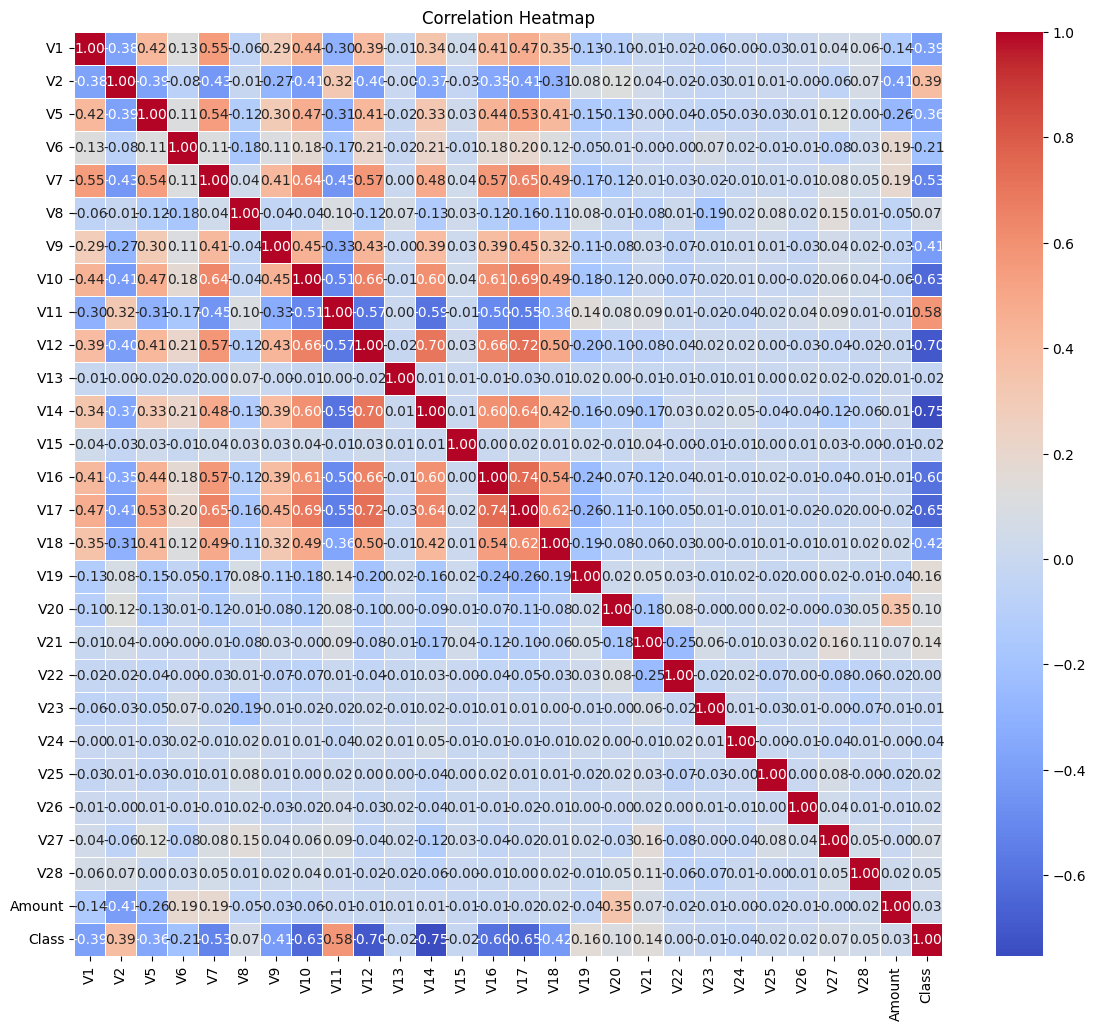

Model: Random Forest
F1 Score: 0.9259

Classification Report:
              precision    recall  f1-score      support
0              0.993713  0.999667  0.996681  3004.000000
1              0.992063  0.868056  0.925926   144.000000
accuracy       0.993647  0.993647  0.993647     0.993647
macro avg      0.992888  0.933861  0.961303  3148.000000
weighted avg   0.993637  0.993647  0.993444  3148.000000


Feature Importance / Coefficients:
  V14: 0.21105830837967474
  V17: 0.15260450315090612
  V10: 0.1325975296661946
  V12: 0.13158502662038365
  V11: 0.0740338607305442
  V16: 0.045403375273188835
  V7: 0.033397589408129785
  V9: 0.028842162032066257
  V18: 0.022927842978385255
  V2: 0.020352341811951384
  V21: 0.013623968331555355
  V13: 0.012018612834489231
  V15: 0.011142413945775167
  V19: 0.010981566354846617
  V6: 0.010213356480313247
  Amount: 0.009347570626034288
  V27: 0.008817126191520804
  V5: 0.00855533521198304
  V26: 0.008465633323942946
  V20: 0.008213315946493178
  V1: 0.0

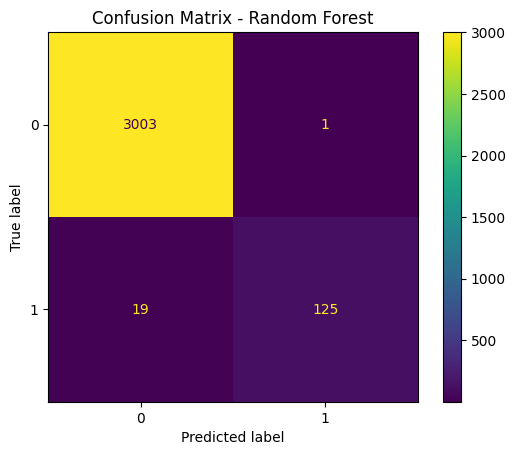

Model: Gradient Boosting
F1 Score: 0.8975

Classification Report:
              precision    recall  f1-score      support
0              0.994350  0.996005  0.995177  3004.000000
1              0.913669  0.881944  0.897527   144.000000
accuracy       0.990788  0.990788  0.990788     0.990788
macro avg      0.954010  0.938975  0.946352  3148.000000
weighted avg   0.990660  0.990788  0.990710  3148.000000


Feature Importance / Coefficients:
  V14: 0.793475778724474
  V12: 0.040608237065862744
  V8: 0.020317057152011944
  V17: 0.0199680039121432
  Amount: 0.019727816216946876
  V1: 0.016303517186588547
  V11: 0.01540841085233577
  V10: 0.013985713825176079
  V9: 0.007500179863778725
  V25: 0.0070701458573992106
  V20: 0.005949523675116773
  V7: 0.005520051668214065
  V16: 0.004561070569358796
  V19: 0.004208967390313642
  V26: 0.0035104915328605098
  V23: 0.003178087744073668
  V15: 0.0028472714756767443
  V6: 0.0025966903448279336
  V24: 0.002207535684516971
  V18: 0.002160696985171432

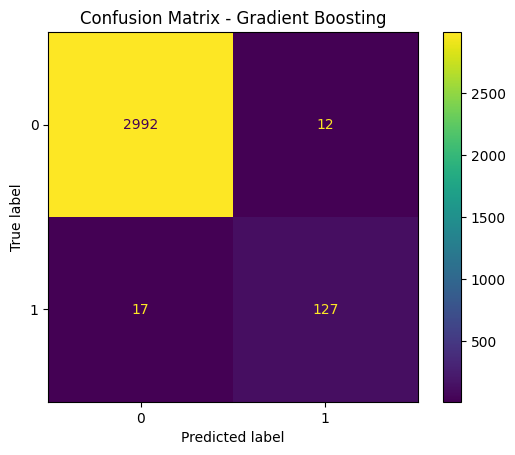

Model: Support Vector Machine
F1 Score: 0.8487

Classification Report:
              precision    recall  f1-score      support
0              0.994980  0.989680  0.992323  3004.000000
1              0.806250  0.895833  0.848684   144.000000
accuracy       0.985388  0.985388  0.985388     0.985388
macro avg      0.900615  0.942757  0.920504  3148.000000
weighted avg   0.986347  0.985388  0.985753  3148.000000


Feature Importance / Coefficients:
  V1: nan
  V2: nan
  V5: nan
  V6: nan
  V7: nan
  V8: nan
  V9: nan
  V10: nan
  V11: nan
  V12: nan
  V13: nan
  V14: nan
  V15: nan
  V16: nan
  V17: nan
  V18: nan
  V19: nan
  V20: nan
  V21: nan
  V22: nan
  V23: nan
  V24: nan
  V25: nan
  V26: nan
  V27: nan
  V28: nan
  Amount: nan


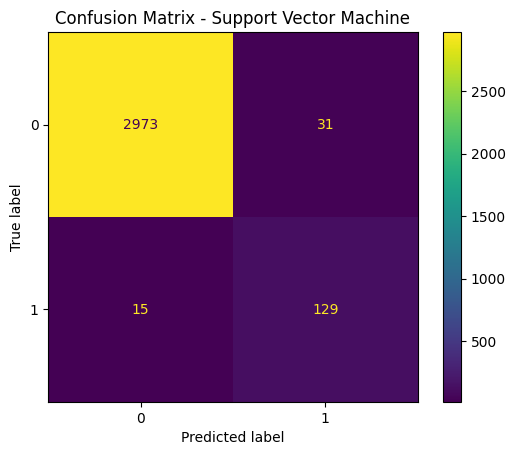

Model: K-Nearest Neighbors
F1 Score: 0.8100

Classification Report:
              precision    recall  f1-score      support
0              0.995288  0.984354  0.989791  3004.000000
1              0.734463  0.902778  0.809969   144.000000
accuracy       0.980623  0.980623  0.980623     0.980623
macro avg      0.864876  0.943566  0.899880  3148.000000
weighted avg   0.983357  0.980623  0.981565  3148.000000


Feature Importance / Coefficients:
  V1: nan
  V2: nan
  V5: nan
  V6: nan
  V7: nan
  V8: nan
  V9: nan
  V10: nan
  V11: nan
  V12: nan
  V13: nan
  V14: nan
  V15: nan
  V16: nan
  V17: nan
  V18: nan
  V19: nan
  V20: nan
  V21: nan
  V22: nan
  V23: nan
  V24: nan
  V25: nan
  V26: nan
  V27: nan
  V28: nan
  Amount: nan


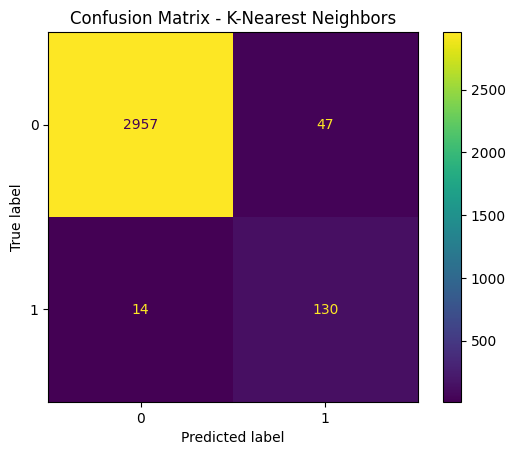

Model: Logistic Regression
F1 Score: 0.7479

Classification Report:
              precision    recall  f1-score      support
0              0.995917  0.974368  0.985024  3004.000000
1              0.631579  0.916667  0.747875   144.000000
accuracy       0.971728  0.971728  0.971728     0.971728
macro avg      0.813748  0.945517  0.866450  3148.000000
weighted avg   0.979251  0.971728  0.974176  3148.000000


Feature Importance / Coefficients:
  V14: -1.7145435381903453
  Amount: 1.584564258023291
  V12: -1.4827017107746405
  V5: 0.9377851016805593
  V2: 0.907759774077191
  V7: -0.8999317081407766
  V1: 0.5963891855202618
  V20: -0.5700668377602692
  V6: -0.4722656540588698
  V16: -0.43942537451352026
  V11: 0.43888036385496015
  V13: -0.4317583484606701
  V8: -0.31479390733585433
  V22: 0.30732662282958345
  V9: -0.2845109714191082
  V17: -0.2189911244407277
  V25: 0.1997302265943532
  V23: 0.16516802507454978
  V10: -0.15157016788972982
  V21: -0.10584772767100446
  V27: -0.0760675766

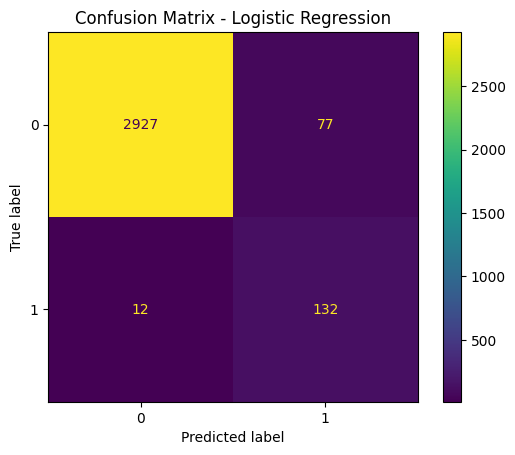

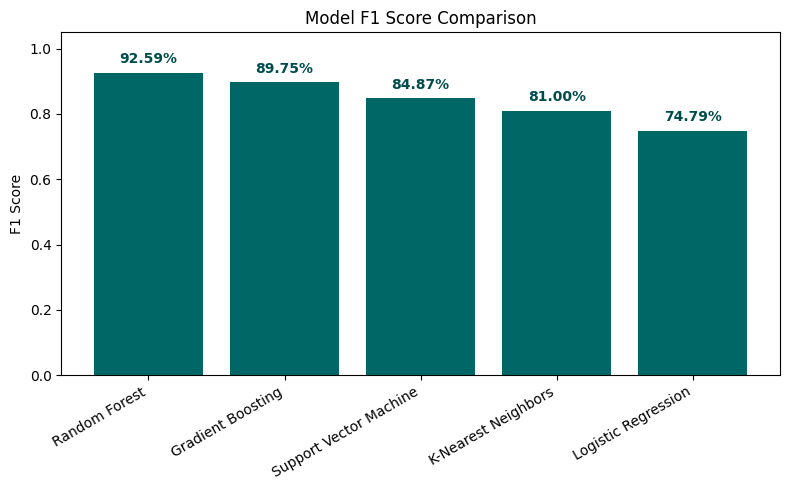

Saved model to:   ~/fraud-model-training-example/model_weights/251022_best_model_codespace/RandomForestClassifier_F1_0.9259.pkl
Saved config to:  ~/fraud-model-training-example/model_weights/251022_best_model_codespace/RandomForestClassifier_F1_0.9259_config.txt


In [31]:
# Return best model based on f1 (or model specified in override) ---
best_model, best_model_f1_score, best_model_feature_names, best_params_per_model, override_used, best_trained_scaler = evaluate_models(
    df,
    target_column=target_flag,
    columns_to_drop=['V3', 'V4', 'Time' # to showcase easy column removal function
                     ],
    overide_best_model="", # "" - means best model used, Gradient Boosting, Logistic Regression, K-Nearest Neighbors, Support Vector Machine, Random Forest
    return_best_params=True
)

# --- Build file names/paths ---
user_name = getpass.getuser()  # use OS username for naming
date = datetime.today().strftime('%y%m%d')

# Save under base path
model_dir = f"~/fraud-model-training-example/model_weights/{date}_best_model_{user_name}/"
os.makedirs(model_dir, exist_ok=True)
best_model_name = type(best_model).__name__
file_name = f"{best_model_name}_F1_{best_model_f1_score:.4f}"

model_path = os.path.join(model_dir, f"{file_name}.pkl")
config_path = os.path.join(model_dir, f"{file_name}_config.txt")

# Friendly name mapping so we can pull the tuned params for the chosen model
friendly_map = {
    "LogisticRegression": "Logistic Regression",
    "RandomForestClassifier": "Random Forest",
    "GradientBoostingClassifier": "Gradient Boosting",
    "SVC": "Support Vector Machine",
    "KNeighborsClassifier": "K-Nearest Neighbors",
}
chosen_model_name = friendly_map.get(best_model_name, best_model_name)

# Save the model weights as pkl
with open(model_path, "wb") as f:
    pickle.dump({"model": best_model, "features": best_model_feature_names, "scaler": best_trained_scaler}, f)

# --- Prepare the plain-text configuration content for model weigths file ---
def _to_jsonable(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, (np.bool_,)):
        return bool(o)
    return str(o)

# Preprocessing flags (based on how your function applies them per model)
smote_models = {"Logistic Regression", "K-Nearest Neighbors", "Gradient Boosting"}
scale_models = {"Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"}
applied_smote = chosen_model_name in smote_models
applied_scaling = chosen_model_name in scale_models

# Safely fetch chosen model params
chosen_params = best_params_per_model.get(chosen_model_name, {})

# Pretty-print dicts as JSON blocks inside the text file
try:
    import json
    chosen_params_txt = json.dumps(chosen_params, indent=2, sort_keys=True, default=_to_jsonable)
    all_params_txt = json.dumps(best_params_per_model, indent=2, sort_keys=True, default=_to_jsonable)
except Exception:
    chosen_params_txt = str(chosen_params)
    all_params_txt = str(best_params_per_model)

# Compose the text content
lines = []
lines.append("# ================= MODEL CONFIGURATION =================")
lines.append(f"Saved on: {datetime.now().isoformat(timespec='seconds')}")
lines.append(f"Saved by: {user_name}")
lines.append("")
lines.append("## Dataset / Target")
lines.append(f"Training Dataset File Used: {training_file}")
lines.append(f"Target column: {target_flag}")
lines.append(f"Number of features: {len(best_model_feature_names)}")
lines.append("Feature names:")
lines.append(", ".join(best_model_feature_names))
lines.append("")
lines.append("## Best Model")
lines.append(f"Best Model Overide Used: {override_used}")
lines.append(f"Class name: {best_model_name}")
lines.append(f"Friendly name: {chosen_model_name}")
lines.append(f"Recall (positive class): {best_model_f1_score:.6f}")
lines.append(f"Applied SMOTE (train only): {applied_smote}")
lines.append(f"Applied StandardScaler (train & test): {applied_scaling}")
lines.append("")
lines.append("Best estimator (repr):")
lines.append(repr(best_model))
lines.append("")
lines.append("## Tuned Hyperparameters — Chosen Model")
lines.append(chosen_params_txt)
lines.append("")
lines.append("## Tuned Hyperparameters — All Models")
lines.append(all_params_txt)
lines.append("")
lines.append("# =================== END OF CONFIG =====================")

# --- Write config to .txt file ---
with open(config_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines)) 

print(f"Saved model to:   {model_path}")
print(f"Saved config to:  {config_path}")